In [490]:
import pandas as pd
import sqlite3
import numpy as np
from sklearn.metrics import pairwise_distances

### Lyrics Similarirty Model:

In [524]:
import numpy as np
import scipy.sparse
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from sklearn.neighbors import KDTree
import sqlite3
from sklearn.metrics import pairwise_distances


class Method1:
    
    def __init__(self, Lyrics="TrackData.csv", Track_Song_Mappings = "Song-Track.csv", Words="Words.txt", Database = "track_metadata.db", Encodings="Encodings_numpy.pickle.npy"):
        
        print("Loading TrackIDs, SongIDs, and Lyrics..")
        self.track_lyrics_df = pd.read_csv(Lyrics)
        self.song_track_df = pd.read_csv(Track_Song_Mappings)
        self.song_track_df = self.song_track_df.rename(columns={'TrackID':'ID'})
        self.track_lyrics_df = self.track_lyrics_df.merge(self.song_track_df)
        self.song_track_df = []
        
        
        

        print("Loading Words..")
        self.words = {}
        f = open(Words)
        for line in f:
            words = line.split(",")
            for i, word in enumerate(words):
                self.words[i+1] = word
        
        print("Loading Track Database..")
        self.db_conn = sqlite3.connect('track_metadata.db')
        
        print("Loading KDD Tree for Lyrics Similarity..")
        self.enc = np.load(Encodings, allow_pickle=True)
        self.tree = KDTree(self.enc, leaf_size=40) 
        
        self.similarSongs = []
        self.temp = pd.DataFrame()
        
        print("Loaded!")
        
        
        
    def getLyrics(self, embeddings, words, with_count = False):
        sentence = ""
  
        embeddings = embeddings.replace("[","")
        embeddings = embeddings.replace("]","")
        embeddings = embeddings.replace("'","")
        embeddings = embeddings.replace(" ","")
        embeddings = embeddings.split(",")

        for emb in embeddings:
            ids = emb.split(":")
            sentence += words[int(ids[0])] + " "

        return sentence
    
    def ShowSongs(self, ret = False, feature = 'Title'):
        songs = self.track_lyrics_df[feature].unique()
        if ret == False:
            print(songs)
        else:
            return songs
        
    def getLyricsSimilarity(self, song, typ = 'Title', k=5):

            index = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
    
            dist, ind = self.tree.query(self.enc[index:index+1], k=int(k)+1)
            self.similarSongs = ind[0]

            self.temp = self.track_lyrics_df[self.track_lyrics_df.index.isin(self.similarSongs)]
            #for row in temp:
                #print("Song: " + row[3] + ", Artist: " + row[4])
            for row in self.temp[['Title','Artist name']].values:
                print("Song:",row[0],", Artist:",row[1])
        
        #except:
        #    print("Unkown Song")
        
    
    def getSimilarTrackID(self, song, typ = 'Title', k=5):
        
        if self.temp.empty:
            index = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
    
            dist, ind = self.tree.query(self.enc[index:index+1], k=int(k)+1)
            self.similarSongs = ind[0]

            self.temp = self.track_lyrics_df[self.track_lyrics_df.index.isin(self.similarSongs)]
            
        
        return self.temp['ID'].values
    
    
    def getSimilarSongID(self, song, typ = 'Title', k=5):
        
        try:
            index = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
        except:
            return [-1]
    
        dist, ind = self.tree.query(self.enc[index:index+1], k=int(k)+1)
        self.similarSongs = ind[0]

        self.temp = self.track_lyrics_df[self.track_lyrics_df.index.isin(self.similarSongs)]
            
        
        return self.temp['SongID'].values
    
        
    def RecommendSongs(self, song, typ = 'Title', k=5):
        
        #song = input()
        self.getLyricsSimilarity(song, typ, int(k))
        
    
    def PairwiseDistanceEvaluation(self, song, typ = 'Title', k=5):
    
        similar_songs = self.getSimilarSongID(song, typ, k)
        
        try:
            idx = self.track_lyrics_df[self.track_lyrics_df[typ] == song].index[0]
            song_emb = self.enc[idx]
            #print("Here")
        except:
            return [-1]
        
        closeness = []
        
        for s in similar_songs:
            idx = self.track_lyrics_df[self.track_lyrics_df['SongID'] == s].index[0]
            sim_emb = self.enc[idx]
            dist = pairwise_distances(song_emb.reshape(-1,len(self.enc[0])),sim_emb.reshape(-1,len(self.enc[0])), metric='cosine')[0][0]
            closeness.append(dist)
            
        return closeness
        
            
            
    
    def LyricCloud(self):
        
        if len(self.similarSongs) == 0:
            print("Choose Song..")
            self.RecommendSongs()
            
        temp = pd.DataFrame()
        temp['Sentence'] = self.temp['Lyrics'].apply(lambda x: self.getLyrics(x, self.words))
        stopwords = set(STOPWORDS)
        comment_words = ""

        # iterate through the csv file
        for val in temp.Sentence:

            # typecaste each val to string
            val = str(val)

            # split the value
            tokens = val.split()

            # Converts each token into lowercase
            for i in range(len(tokens)):
                tokens[i] = tokens[i].lower()

            comment_words += " ".join(tokens)+" "
            
        
        wordcloud = WordCloud(width = 800, height = 800, background_color ='white',
                              stopwords = stopwords, min_font_size = 10).generate(comment_words)
 
        # plot the WordCloud image                      
        plt.figure(figsize = (5, 5), facecolor = None)
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.tight_layout(pad = 0)
        plt.show()

        

### Hybrid Model:

In [ ]:
import pandas as pd
import numpy as np
import pickle
import sqlite3
from tqdm import tqdm

db_conn = sqlite3.connect('track_metadata.db')
sql_query = pd.read_sql_query (''' SELECT * FROM songs ''', db_conn)
tracks = pd.DataFrame(sql_query)

# file locs
sim_users = pickle.load(open('user_user_similar.pkl', 'rb'))
df_path = 'train_triplets.txt'
idx_to_user = pickle.load(open('idx_to_user.pkl', 'rb'))
user_to_idx = pickle.load(open('user_to_idx.pkl', 'rb'))


class UserSimilarityModel():
    def __init__(self, sim_users, df_path):    
        self.sim_users = sim_users
        self.df = pd.concat([chunk for chunk in 
        tqdm(pd.read_csv(df_path, sep = '\t', index_col=None, names = ['User','Song', 'Count'],  chunksize=1000), 
        desc='Loading User-Song Database')])
        self.lyrics_sim = Method1()

    def get_similar_users(self, user):
        return self.sim_users[user]

    def get_most_played(self, user_idx, names = False):
        maxplay = self.df[self.df.index==user_idx]['Song'].value_counts().index[:5].tolist()
        if names:
            temp = []
            for song in maxplay:
                temp.append(self.get_song_from_trackID(song))
            return temp
        else:
            return maxplay

    def get_recommendations(self, user_idx):
        similar_users = self.get_similar_users(user_idx)
        top_songs = []
        for user in similar_users:
            top_songs.extend(self.get_most_played(user))
            top_songs = list(set(top_songs))
            for songs in self.get_most_played(user_idx):
                if songs in top_songs:
                    top_songs.remove(songs)
                '''
                sim_list = self.lyrics_sim.getSimilarSongID(song)
                top_songs = top_songs.merge(sim_list)
                '''
            
                
        return self.sort_by_familiarity(top_songs)
    
    def get_song_from_trackID(self, track):
        return tracks[tracks['track_id']==track]

    def sort_by_familiarity(self, top_songs):
        subset_tracks = tracks[tracks['track_id'].isin(top_songs)]
        subset_tracks = subset_tracks.sort_values(by=['artist_familiarity'], ascending=False)
        return subset_tracks['title'].values[:5]
    


In [525]:
model1 = Method1()
model2 = UserSimilarityModel()

Loading TrackIDs, SongIDs, and Lyrics..
Loading Words..
Loading Track Database..
Loading KDD Tree for Lyrics Similarity..
Loaded!


In [579]:
model1.ShowSongs()

['A Poor Recipe For Civic Cohesion' 'Soul Deep' "It's About Time" ...
 'No Angels' 'Dear Lie' 'Trans-Island Skyway (Album Version)']


In [581]:
model1.RecommendSongs('A Poor Recipe For Civic Cohesion','Title',5)

Song: A Poor Recipe For Civic Cohesion , Artist: Western Addiction
Song: Scavenger Of Human Sorrow , Artist: Death
Song: River Of Deceit , Artist: Mad Season
Song: Eleven Miles Out , Artist: Doves
Song: On the Throne , Artist: Altar
Song: Nebraska , Artist: The Lawrence Arms


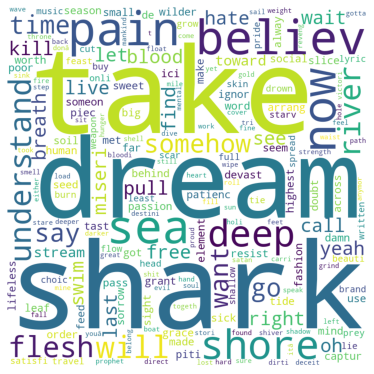

In [582]:
model1.LyricCloud()

### Model 1 Lyrics Similarity: 

In [546]:
def EvaluateLyricsSimilarity(model=model, k=5):
    #print(k)
    temp_df = model.track_lyrics_df['SongID'].sample(int(k))
    SongIDs = temp_df.values
    
    closeness = []
    
    for s in tqdm(SongIDs):
        cls = model.PairwiseDistanceEvaluation(song=s,typ='SongID',k= 5)
        closeness.append(np.mean(cls))
    
    print("Lyrics similarity for recommended songs for " + str(k) + " songs: ", np.mean(closeness))
        
        

In [548]:
EvaluateLyricsSimilarity(model=model, k=500)

100%|██████████| 500/500 [04:08<00:00,  2.01it/s]

Lyrics similarity for recommended songs for 500 songs:  0.06872204


## Evaluation 1:

In [574]:
from tqdm import tqdm

def Evaluate1(model, k=500, user_k=10):
    
    popular_songs = user.groupby('SongID').agg({'SongID':'size'}).rename(columns={'SongID':'Users'})
    popular_songs = popular_songs.reset_index()
    popular_songs = popular_songs.sort_values(by=['Users'], ascending=False)
    popular_songs_list = popular_songs['SongID'].head(k).to_list()
    
    not_in_model = 0
    users_who_listened = []
    fraction = []
    
    for s in tqdm(popular_songs_list):
        
        pred = model.getSimilarSongID(song=s, typ='SongID', k=10)
        #print(s, pred)

        if pred[0] == -1:
            not_in_model +=1
            continue
          
        
        for ind in range(len(pred)):
            if s == pred[ind]:
                #print(pred, ind)
                p = np.delete(pred, ind)
                #print(p)
          
        user_list = user[user['SongID'] == s].sort_values(by=['Count'],ascending=False)
        user_list = user_list.head(user_k)

        user_list = user_list['User'].values
        tot = user[user['User'].isin(user_list)]
        count = len(tot[tot['SongID'].isin(p)]['User'].unique())
        frac = len(user_list)

        
        users_who_listened.append(count)
        fraction.append(frac)
        
    
    return users_who_listened, fraction, not_in_model
        

In [575]:
a, b, c = Evaluate1(model1)

100%|██████████| 500/500 [06:34<00:00,  1.27it/s]


In [576]:
res = [(i / j)*100 for i, j in zip(a, b)]
print("Evaluation 1 accuracy with all users:",np.mean(res))
print("Evaluation 1 accuracy for at least one of the top k users:",np.mean(a)*100)

Evaluation 1 accuracy with all users: 0.8189655172413793
Evaluation 1 accuracy for at least one of the top k users: 8.189655172413794


In [620]:
a, b, c = Evaluate1(model2)

100%|██████████| 500/500 [07:38<00:00,  1.09it/s]


In [623]:
res = [(i / j)*100 for i, j in zip(a, b)]
print("Evaluation 1 accuracy with all users:",np.mean(res))
print("Evaluation 1 accuracy for at least one of the top k users:",np.mean(a)*100)

Evaluation 1 accuracy with all users: 0.42568638874
Evaluation 1 accuracy for at least one of the top k users: 42.568638874


## Evaluation 2:

* Select Random popular songs.
* For a song,
    * Select k users who listen to this song frequently.
    * Recommend songs.
    * Find top 5 similar users for k users. 
    * Check if they had listened to this song.
  

In [ ]:
from pandas.api.types import CategoricalDtype

In [583]:
user_dup = pd.read_csv("train_triplets.txt",sep="\t",names=['User','SongID','Count'])
user_user = np.load("user_user_similar.pkl", allow_pickle=True)

In [603]:
user_user = np.load("user_user_similar.pkl", allow_pickle=True)

In [611]:
users = np.array(list(np.sort(user_dup['User'].unique())))
users = users[500000:]

rows = user_dup[user_dup['User'].isin(users)]['User'].astype(CategoricalDtype(categories=users)).cat.codes

In [614]:
from tqdm import tqdm

def ind_to_user(x):
    return users[x]

def Evaluate2(model, songs_k = 50, user_k=10):
    
    popular_songs = user.groupby('SongID').agg({'SongID':'size'}).rename(columns={'SongID':'Users'})
    popular_songs = popular_songs.reset_index()
    popular_songs = popular_songs.sample(10000)
    popular_songs = popular_songs.sort_values(by=['Users'], ascending=False)
    popular_songs_list = popular_songs['SongID'].head(songs_k).to_list()
    
    not_in_model = 0
    users_who_listened = []
    fraction = []
    unknown_users = 0

    
    overall_acc = []
    
    for s in tqdm(popular_songs_list):
        print("Song: ", s)
        
        pred = model.getSimilarSongID(song=s, typ='SongID', k=10)
        #print(s, pred)

        if pred[0] == -1:
            not_in_model +=1
            continue
          
        
        for ind in range(len(pred)):
            if s == pred[ind]:
                #print(pred, ind)
                p = np.delete(pred, ind)
                #print(p)
          
        user_list = user[user['SongID'] == s].sort_values(by=['Count'],ascending=False)
        user_list = user_list.head(user_k)
        user_list = user_list['User'].values
        
        song_accuracy = []
        i = 0
        print("Total Users: ", len(user_list))
        for u in user_list:
            print("User:",i)
            i+=1
            try:
                ind = np.where(users == u)[0][0]
            except:
                unknown_users +=1
                continue
            try:
                sim_users = user_user[ind]
                sim_users = list(map(ind_to_user,sim_users))
            except:
                unknown_users +=1
                continue
            
            accuracy = 0
            
            print("Checking Similar Users..")
            
            for sim_u in sim_users:
                temp_songs = user[user['User'] == sim_u]['SongID'].unique()
                acc = 0
                for s_id in p:
                    if s_id in temp_songs:
                        print("MATCH")
                        acc+=1
                        break
                    if acc==1:
                        break
                        
                accuracy += acc
                    
            
            song_accuracy.append(accuracy)
            
        if len(song_accuracy) > 0:    
            perc = np.mean(song_accuracy)
            overall_acc.append(perc)

        
    
    return overall_acc, unknown_users, not_in_model
        

In [ ]:
acc, ukn_users, ukn_songs = Evaluate2(model1, songs_k = 50, user_k=10)

In [616]:
print("Suggested ",np.mean(acc))

Suggested  0.030701754385964907


In [625]:
acc, ukn_users, ukn_songs = Evaluate2(model2, songs_k = 50, user_k=10)


In [626]:
print("Suggested ",np.mean(acc))

Suggested  0.37915975978
